In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp

Tovlap = 5e-7
NSamp = 2000
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
DTSamp   = Th/NSamp
wlH, wrH = -1.6e-9, 1.6e-9

NSampext = math.ceil( Tovlap/DTSamp )


In [2]:
n_particles = 20000
#n_particles = 1
wlH, wrH = -1.6e-9, 1.6e-9
wlL, wrL = -1.6e-9, 1.6e-9
ptsEarly = np.random.randn( n_particles, 4) @ np.diag((1e-3,1e-3,1e-4,Th*2))

In [3]:
# compute t of standard time traces, for better plottings
ind = np.arange( (-NSampext) , (NSamp+1+NSampext) )
t_time_trace = ind*DTSamp - Th/2 

In [4]:
def respH( Dt ):
    if Dt < 1.*wlH or Dt > 1.*wrH:
        print( f' ===> function respH called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7

# Routine to generate time traces
def TimeTraces( ptsEarly ):
    TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceL = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau) )
    for x, xp, delt, Tau in ptsEarly:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) ):
            # I simplified, calling again same function... 
            TraceL[ind] += respH(ind*DTSamp -Th/2- (Tau-Th) )

      
    return TraceH, TraceL

In [5]:
def respH_new( Dt ):
    # 0) remove if statement, or make it at least array-compatible 
    #   -> Note: if you remove it, this will save you some extra time! Consider keeping it commented, and un-comment it only for debug
    #if Dt < 1.*wlH or Dt > 1.*wrH:
    if np.any( (Dt < 1.*wlH) | (Dt > 1.*wrH) ):
        for Dt_ in Dt[(Dt < 1.*wlH) | (Dt > 1.*wrH)]:
            print( f' ===> function respH called with Dt ={1e6*Dt_:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7

# Routine to generate time traces
def TimeTraces_new( ptsEarly ):
    
    # 1) Replace list to zeros array 
    #TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceH = np.zeros(NSamp + 1 + 2*NSampext)
    TraceL = np.zeros(NSamp + 1 + 2*NSampext)

    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation

        # 2) replace for loop by a simple evaluation over all needed indexes
        #for ind in range( max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)), 
        #                  min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) ):
        #    TraceH[ind] += x*respH_new(ind*DTSamp -Th/2- (Tau-Th) )

        ind = np.arange(max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)),  
                        min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) )
        TraceH[ind] += x*respH_new(ind*DTSamp -Th/2- (Tau-Th) )
    
    # 3) in principle one could put in the same loop on pstEarly, compute also TraceL... 
    #    --> but it seems to be slightly slower... to be further tested...
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        ind = np.arange( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                        min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) )
        TraceL[ind] += respH_new(ind*DTSamp -Th/2- (Tau-Th) )
            
    return TraceH, TraceL

### Changing completly approach:
- convolute "histogram" of beam distribution seen by the pickup and the time response of the s-cooling system
- In this case, the "beam histogram" is computed only once at every passage of the beam in the pickup
- No need of interpolation (embedded in the hisotram)
- Time response of a single particle is coputed only once at the beginning of the code (no need to recompute it at every turn)
- Drawback: In this case, we need to "oversample" wrt to previous approach the beam distribution (and hence the response)

In [6]:
# Oversampling of time trace, wrt to previous approach, to improve matching between two approcies
over_sample_factor = 10

# compute the response only once
respH_new_once = respH_new(np.arange(wlH, wrH, DTSamp/over_sample_factor))

# Define bins where to sample histograms of beam distribution, having same time resolution as desired response
ind = np.arange( (-NSampext)*over_sample_factor , (NSamp+1+NSampext + 1)*over_sample_factor )
t_bins = ind*DTSamp/over_sample_factor -Th/2



# define a function to make running average and counts on beam distribution
def running_average(x, y, bins):
    """
    Compute the running average of y over fixed intervals in x efficiently using NumPy.

    Parameters:
    x (array-like): Array of x-values (sorted or unsorted).
    y (array-like): Array of y-values corresponding to x.
    interval_width (float): The width of the intervals.

    Returns:
    bin_centers (numpy.ndarray): The centers of the bins.
    averages (numpy.ndarray): The average y-values for each bin.
    """
    # Ensure inputs are NumPy arrays
    x = np.array(x)
    y = np.array(y)

    # Bin the data using NumPy digitize
    bin_indices = np.digitize(x, bins) - 1  # Get zero-based bin indices

    # keep only elements within bins
    valid_input_indices = (bin_indices > 0) & (bin_indices < len(bins) - 1)

    # Preallocate array for averages
    averages = np.zeros(len(bins) - 1, dtype=float)
    
    # Use NumPy's bincount for fast bin-based summation and counts
    bin_sums   = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1, weights=y[valid_input_indices])
    bin_counts = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1)
    
    # Avoid division by zero: compute averages where bin_counts > 0
    non_empty_bins = bin_counts > 0
    averages[non_empty_bins] = bin_sums[non_empty_bins] / bin_counts[non_empty_bins]

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    return bin_centers, averages, bin_counts, bin_sums


# Routine to generate time traces
def TimeTraces_new2( ptsEarly ):
    # Compute histograms of beam distribution over tau...
    bin_centers, averages, bin_counts, bin_sums = running_average(ptsEarly[:, 3]-Th, ptsEarly[:, 0], t_bins)

    # compute time trance as convolution
    TraceH = np.convolve(respH_new_once, bin_sums, 'same')
    TraceL = np.convolve(respH_new_once, bin_counts, 'same')
     
    return bin_centers, TraceH, TraceL

 ===> function respH called with Dt =  0.0016


In [7]:
old_codeH, old_codeL = TimeTraces(ptsEarly)

In [8]:
new_codeH, new_codeL = TimeTraces_new(ptsEarly)

In [9]:
new_2_bin_centers, new2_codeH, new2_codeL = TimeTraces_new2(ptsEarly)

# I didn't fully understand this offset... the time defintion/intervals are not fully clear to me.
new_2_t_time_trace =  new_2_bin_centers +Th+Tovlap+DTSamp

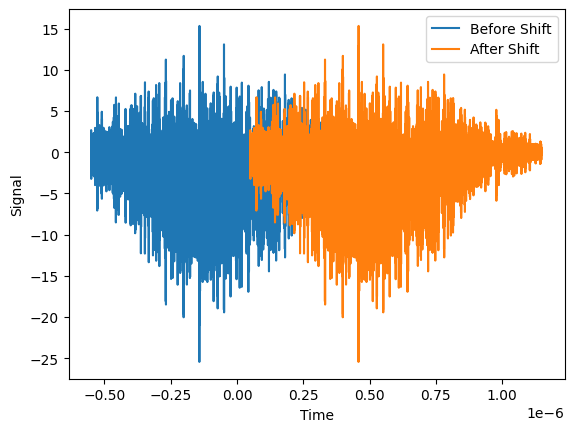

In [10]:
plt.plot(new_2_bin_centers, new2_codeL, label="Before Shift")
plt.plot(new_2_t_time_trace, new2_codeL, label="After Shift")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()

In [11]:
y_values = np.concatenate((old_codeL[-NSampext:], old_codeL[:NSamp + 1 + NSampext]))


cs=sp.interpolate.CubicSpline(t_time_trace,y_values)
csnew=sp.interpolate.CubicSpline(new_2_bin_centers,np.array(new2_codeL))

(5.3e-07, 5.35e-07)

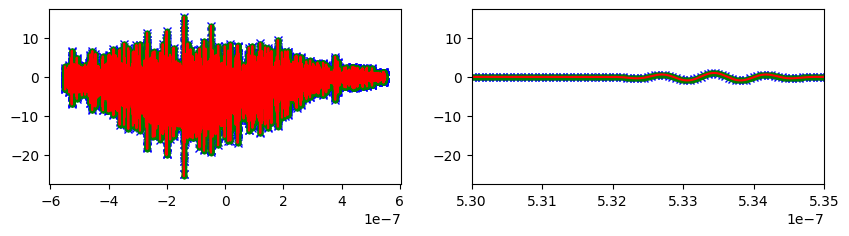

In [13]:
plt.figure(figsize=[10, 5])
plt.subplot(2,2,1)
plt.plot(t_time_trace, cs(t_time_trace), 'bx')
plt.plot(new_2_bin_centers, new2_codeL, 'g.',alpha=0.65 )
plt.plot(new_2_bin_centers,csnew(new_2_bin_centers), 'r')
    #in order to plot, we shift back to real time??? why? -> we shift back to new_2_bin_centers



plt.subplot(2,2,2)
plt.plot(t_time_trace, cs(t_time_trace), 'bx')
#plt.plot(t_time_trace, new_codeH, 'r.')
plt.plot(new_2_bin_centers, new2_codeL, 'g.', alpha=0.65)
plt.plot(new_2_bin_centers,csnew(new_2_bin_centers), 'r')
plt.xlim([5.3e-7, 5.35e-7])




In [48]:
print(np.allclose(new_2_bin_centers + (Th + Tovlap + DTSamp), new_2_t_time_trace))
print(np.allclose(new2_codeH, csnew(new_2_t_time_trace)))
print(np.allclose(new_2_bin_centers, new_2_t_time_trace))

True
True
False


(6.3e-07, 6.35e-07)

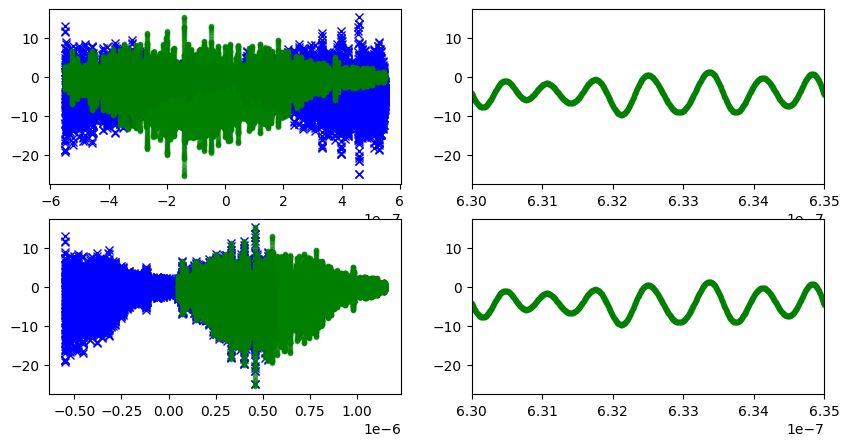

In [14]:
plt.figure(figsize=[10, 5])
plt.subplot(2,2,1)
plt.plot(t_time_trace, old_codeL, 'bx')
#plt.plot(t_time_trace, new_codeH, 'r.')
plt.plot(new_2_bin_centers, new2_codeL, 'g.', alpha=0.15)

# zoom version
plt.subplot(2,2,2)
plt.plot(t_time_trace, old_codeL, 'bx')
#plt.plot(t_time_trace, new_codeH, 'r.')
plt.plot(new_2_t_time_trace, new2_codeL, 'g.', alpha=0.65)
plt.xlim([6.3e-7, 6.35e-7])

plt.subplot(2,2,3)
plt.plot(t_time_trace, old_codeL, 'bx')
#plt.plot(t_time_trace, new_codeL, 'r.')
plt.plot(new_2_t_time_trace, new2_codeL, 'g.', alpha=0.15)

# zoom version
plt.subplot(2,2,4)
plt.plot(t_time_trace, old_codeL, 'bx')
#plt.plot(t_time_trace, new_codeL, 'r.')
plt.plot(new_2_t_time_trace, new2_codeL, 'g.', alpha=0.65)
plt.xlim([6.3e-7, 6.35e-7])

### Observations:
1. Note that both approaches give approximatelly the same result. 
2. Time axis to be better understood -> possibly need to clean up better the code
3. border effects in the convolution approach to be carefully looked at
4. this approach open up to use FFT multiplications instead of convolution, which should give the same result and allows to directly embed and/or split the s-cooling chain + noise sources as desired

### Profiling the functions

In [19]:
from timeit import timeit

In [20]:
timeit('TimeTraces(ptsEarly)', globals=globals(), number=10)


22.630256909003947

In [21]:
timeit('TimeTraces_new(ptsEarly)', globals=globals(), number=10)


6.23782689699874

In [22]:
timeit('TimeTraces_new2(ptsEarly)', globals=globals(), number=10)


0.3521122000020114